# Previsao dos Modelos

In [77]:
import pandas as pd
import statsmodels.api as sm
import numpy as np

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

import warnings
warnings.filterwarnings('ignore')

%load_ext rpy2.ipython
import rpy2.robjects as robjects
robjects.r("library(forecast)")
from IPython.display import clear_output
clear_output()

from statsmodels.tsa.holtwinters import ExponentialSmoothing
import numpy as np
import pandas as pd

pd.options.plotting.backend = "plotly"
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"

In [78]:
dados = pd.read_csv('dataset/dataset_total.csv').set_index('Data').Consumo/1000
teste = dados[-36:]
dados = dados[:-36]

In [105]:
#Previsao Ingênua
y_pred_ingenuo = np.array([dados[-12:].values]*3).reshape(-1,1)

#SARIMA
model1 = mod = sm.tsa.statespace.SARIMAX(dados, order=(1,0,0), seasonal_order=(0,1,1,12), use_exact_diffuse=True).fit()
y_pred_sarima = model1.forecast(36) 

#Holt-Winters
model2 = ExponentialSmoothing(dados, 
                            trend='add', damped_trend=False, seasonal='add', seasonal_periods=12, use_boxcox=True, 
                            initialization_method='estimated', missing='drop').fit()
y_pred_hw = model2.forecast(36) 

In [80]:
%%R
df <- read.csv(file = "dataset/dataset_total.csv")
total <- ts(df$Consumo, start = "2004", frequency = 12)

train <- head(total, -36)
test <- tail(total, 36)

results <- forecast(nnetar(train,p=1,P=1, repeats = 50), h=36)

In [81]:
nn_resid = robjects.r('results$resid')
y_pred_nn = robjects.r('results$mean')

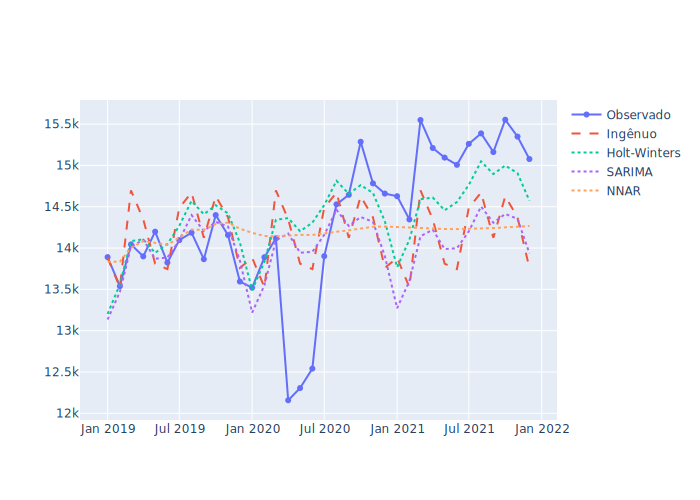

In [106]:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        mode='lines+markers', x=teste.index, y = teste.values,
        name = 'Observado'
    ))
fig.add_trace(
    go.Scatter(
      x=teste.index, y=y_pred_ingenuo.reshape(-1,),
      line = dict(dash='dash'), name = 'Ingênuo',
    ))
fig.add_trace(
    go.Scatter(
      x=teste.index, y=y_pred_hw.values.reshape(-1,),
      line = dict(dash='dot'), name = 'Holt-Winters',
    ))
fig.add_trace(
    go.Scatter(
      x=teste.index, y=y_pred_sarima.values.reshape(-1,),
      line = dict(dash='dot'), name = 'SARIMA',
    ))
fig.add_trace(
    go.Scatter(
      x=teste.index, y=(np.array(y_pred_nn)/1000).reshape(-1,),
      line = dict(dash='dot'), name = 'NNAR',
    ))
fig.show()

In [107]:
def res(y_pred, results, nome):
    print('\n'+nome)
    print('  MAPE', mean_absolute_percentage_error(teste.values, y_pred)*100, '\n  RMSE', mean_squared_error(teste.values, y_pred, squared=False))

In [109]:
print('Ingênuo')
print('  MAPE', mean_absolute_percentage_error(teste.values, y_pred_ingenuo)*100, '\n  RMSE', mean_squared_error(teste.values, y_pred_ingenuo, squared=False))
print()
res(y_pred_sarima, model1.resid, 'Sarima')
res(y_pred_hw, model2.resid, 'Holt-Winters')
res(np.array(np.array(y_pred_nn)/1000), pd.Series(nn_resid).dropna(), 'NNAR')


Ingênuo
  MAPE 4.76195971143994 
  RMSE 819.7539457932453


Sarima
  MAPE 4.621855958782976 
  RMSE 842.727130661813

Holt-Winters
  MAPE 3.5841732298462423 
  RMSE 702.7975761646267

NNAR
  MAPE 4.391149968627566 
  RMSE 819.148937316471
